# Animating NEXRAD Level II Data
---

## Overview
   
Within this notebook, we will cover:

1. Exploring the "guts" of a NEXRAD radar file 
1. Animating a sequence of AWS-served NEXRAD Level 2 Radar scans

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Cartopy Intro](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Required | Projections and Features |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Required | Basic plotting |
| [Py-ART Basics](../foundations/pyart-basics) | Required | IO/Visualization |

- **Time to learn**: 20 minutes
---

## Imports

In [3]:
import pyart
import fsspec
from metpy.plots import USCOUNTIES, ctables
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
from datetime import datetime as dt
from datetime import timedelta

import matplotlib
matplotlib.rcParams['animation.html'] = 'html5'
from matplotlib.animation import ArtistAnimation

warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


## Select the time and NEXRAD site

In [4]:
datTime = dt(2013,5,20,19)
year = dt.strftime(datTime,format="%Y")
month = dt.strftime(datTime,format="%m")
day = dt.strftime(datTime,format="%d")
hour = dt.strftime(datTime,format="%H")
timeStr = f'{year}{month}{day}{hour}'

site = 'KTLX'

Point to the [AWS S3 filesystem](https://aws.amazon.com/s3/)

In [5]:
fs = fsspec.filesystem("s3", anon=True)

Depending on the year, the radar files will have different naming conventions. 

In [6]:
pattern1 = f's3://noaa-nexrad-level2/{year}/{month}/{day}/{site}/{site}{year}{month}{day}_{hour}*V06'
pattern2 = f's3://noaa-nexrad-level2/{year}/{month}/{day}/{site}/{site}{year}{month}{day}_{hour}*V*.gz'
pattern3 = f's3://noaa-nexrad-level2/{year}/{month}/{day}/{site}/{site}{year}{month}{day}_{hour}*.gz'

Construct the URL pointing to the radar file directory and get a list of matching files.

Try each file pattern. Once the list of files is non-empty, we are all set.

In [7]:
files = sorted(fs.glob(pattern1))

if (len(files) == 0):
    files = sorted(fs.glob(pattern2))  

if (len(files) == 0):
    files = sorted(fs.glob(pattern3))   

If we still have an empty list, either there are no files available for that site/date, or the file name does not match any of the patterns above. 

In [8]:
if (len(files) == 0):
    print ("There are no files found for this date and location. Either try a different date/site, \
or browse the NEXRAD2 archive to see if the file name uses a different pattern.")
else:
    print (files)

['noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_190411_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_190826_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_191243_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_191658_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_192116_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_192532_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_192949_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_193405_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_193821_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_194238_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_194655_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_195111_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_195527_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_195941_V06.gz']


## Read the Data into PyART

Read in the first radar file in the group and list the available fields.

In [9]:
radar = pyart.io.read_nexrad_archive(f's3://{files[0]}')
list(radar.fields)

['cross_correlation_ratio',
 'velocity',
 'differential_phase',
 'differential_reflectivity',
 'reflectivity',
 'spectrum_width']

The `radar` object has a lot of useful data ... and *metadata*! One way to look at the attributes of any Python object is to use the `vars` function. It returns a Python `dictionary`; each dictionary `key` has an associated value ... which might be a single value ... a list of values ... another dictionary ... and so on.

In [10]:
radarDict = vars(radar)

In [11]:
radarDict

{'time': {'units': 'seconds since 2013-05-20T19:04:11Z',
  'standard_name': 'time',
  'long_name': 'time_in_seconds_since_volume_start',
  'calendar': 'gregorian',
  'comment': 'Coordinate variable for time. Time at the center of each ray, in fractional seconds since the global variable time_coverage_start',
  'data': array([1.76000e-01, 1.98000e-01, 2.20000e-01, ..., 2.47596e+02,
         2.47631e+02, 2.47664e+02])},
 'range': {'units': 'meters',
  'standard_name': 'projection_range_coordinate',
  'long_name': 'range_to_measurement_volume',
  'axis': 'radial_range_coordinate',
  'spacing_is_constant': 'true',
  'comment': 'Coordinate variable for range. Range to center of each bin.',
  'data': array([  2125.,   2375.,   2625., ..., 459375., 459625., 459875.],
        dtype=float32),
  'meters_to_center_of_first_gate': 2125.0,
  'meters_between_gates': 250.0},
 'fields': {'cross_correlation_ratio': {'units': 'ratio',
   'standard_name': 'cross_correlation_ratio_hv',
   'long_name': 'Cr

We can get a list of all the individual keys in the dictionary:

In [12]:
radarDict.keys()

dict_keys(['time', 'range', 'fields', 'metadata', 'scan_type', 'latitude', 'longitude', 'altitude', 'altitude_agl', 'sweep_number', 'sweep_mode', 'fixed_angle', 'sweep_start_ray_index', 'sweep_end_ray_index', 'target_scan_rate', 'rays_are_indexed', 'ray_angle_res', 'azimuth', 'elevation', 'scan_rate', 'antenna_transition', 'rotation', 'tilt', 'roll', 'drift', 'heading', 'pitch', 'georefs_applied', 'instrument_parameters', 'radar_calibration', 'ngates', 'nrays', 'nsweeps', 'projection', 'rays_per_sweep', 'gate_x', 'gate_y', 'gate_z', 'gate_longitude', 'gate_latitude', 'gate_altitude'])

The first key is `time`. Let's look at it:

In [13]:
radarDict['time']

{'units': 'seconds since 2013-05-20T19:04:11Z',
 'standard_name': 'time',
 'long_name': 'time_in_seconds_since_volume_start',
 'calendar': 'gregorian',
 'comment': 'Coordinate variable for time. Time at the center of each ray, in fractional seconds since the global variable time_coverage_start',
 'data': array([1.76000e-01, 1.98000e-01, 2.20000e-01, ..., 2.47596e+02,
        2.47631e+02, 2.47664e+02])}

It's also a Python dictionary! It's shorter than its parent's ... so we can see that there are six keys. Let's look at the first one, `units`.

In [14]:
radarDict['time']['units']

'seconds since 2013-05-20T19:04:11Z'

It's a string ... and a useful one ... as it provides a base time that we can use to infer timestamps for the start of each of the individual sweeps that make up the full volume scan of this particular radar file.

Let's look at `time`'s `data` key:

In [15]:
radar.time['data'] # equivalent to: radarDict['time']['data']

array([1.76000e-01, 1.98000e-01, 2.20000e-01, ..., 2.47596e+02,
       2.47631e+02, 2.47664e+02])

<div class="alert alert-info"><b>Note: </b>Each key in the top-level <code>radar</code> dictionary can be accessed as an <i>attribute</i> in the <code>radar</code> object itself. 

<div class="alert alert-warning"><b>Question: </b>What does each value represent, in terms of <i>time</i>?</div>

How many elements are in this array?

In [16]:
len(radar.time['data'])

8280

Other keys include `longitude` and `latitude`. Let's have a look at them:

In [17]:
radarDict['longitude'], radarDict['latitude']

({'long_name': 'Longitude',
  'standard_name': 'Longitude',
  'units': 'degrees_east',
  'data': array([-97.27748108])},
 {'long_name': 'Latitude',
  'standard_name': 'Latitude',
  'units': 'degrees_north',
  'data': array([35.3330574])})

These are also dictionaries! What do you think the `data` keys represent in both of them?

<div class="alert alert-warning"><b>Exercise: </b> Write code cells to explore the `sweep_number` and `elevation` keys.</div>

In [18]:
radarDict['sweep_number']

{'units': 'count',
 'standard_name': 'sweep_number',
 'long_name': 'Sweep number',
 'data': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=int32)}

In [19]:
radarDict['elevation']

{'units': 'degrees',
 'standard_name': 'beam_elevation_angle',
 'long_name': 'elevation_angle_from_horizontal_plane',
 'axis': 'radial_elevation_coordinate',
 'comment': 'Elevation of antenna relative to the horizontal plane',
 'data': array([ 0.63446045,  0.66741943,  0.6591797 , ..., 19.555664  ,
        19.555664  , 19.555664  ], dtype=float32)}

In [20]:
radarDict['elevation']['data']

array([ 0.63446045,  0.66741943,  0.6591797 , ..., 19.555664  ,
       19.555664  , 19.555664  ], dtype=float32)

What is the length of the data array associated with elevation?

In [21]:
len(radarDict['elevation']['data'])

8280

<div class="alert alert-warning"><b>Consider: </b>How does the array size for elevation and time compare to the array size for sweep index number? What do you think that ratio implies? Is it the same ratio for all sweeps?</div>

In [22]:
cLon, cLat = radar.longitude['data'], radar.latitude['data']
cLon, cLat

(array([-97.27748108]), array([35.3330574]))

Specify latitude and longitude bounds for the resulting maps, the resolution of the cartographic shapefiles, and the desired sweep level.

In [23]:
lonW = cLon - 2
lonE = cLon + 2
latS = cLat - 2
latN = cLat + 2
domain = lonW, lonE, latS, latN

res = '10m'
sweep = 0

Define a function that will determine at which ray a particular sweep begins; also define some strings for the figure title.

In [24]:
def nexRadSweepTimeElev (radar, sweep):
    
    sweepRayIndex = radar.sweep_start_ray_index['data'][sweep]

    baseTimeStr = radar.time['units'].split()[-1]
    baseTime = dt.strptime(baseTimeStr, "%Y-%m-%dT%H:%M:%SZ")

    timeSweep = baseTime + timedelta(seconds=radar.time['data'][sweepRayIndex])

    timeSweepStr = dt.strftime(timeSweep, format="%Y-%m-%d %H:%M:%S UTC")

    elevSweep = radar.fixed_angle['data'][sweep]
    elevSweepStr = f'{elevSweep:.1f}°'
    return timeSweepStr, elevSweepStr

In [25]:
radar.sweep_start_ray_index

{'long_name': 'Index of first ray in sweep, 0-based',
 'units': 'count',
 'data': array([   0,  720, 1440, 2160, 2880, 3600, 4320, 4680, 5040, 5400, 5760,
        6120, 6480, 6840, 7200, 7560, 7920], dtype=int32)}

In [26]:
radar.sweep_number

{'units': 'count',
 'standard_name': 'sweep_number',
 'long_name': 'Sweep number',
 'data': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=int32)}

In [27]:
field = 'reflectivity'
shortName = 'REFL'

In [28]:
vars(radar)

{'time': {'units': 'seconds since 2013-05-20T19:04:11Z',
  'standard_name': 'time',
  'long_name': 'time_in_seconds_since_volume_start',
  'calendar': 'gregorian',
  'comment': 'Coordinate variable for time. Time at the center of each ray, in fractional seconds since the global variable time_coverage_start',
  'data': array([1.76000e-01, 1.98000e-01, 2.20000e-01, ..., 2.47596e+02,
         2.47631e+02, 2.47664e+02])},
 'range': {'units': 'meters',
  'standard_name': 'projection_range_coordinate',
  'long_name': 'range_to_measurement_volume',
  'axis': 'radial_range_coordinate',
  'spacing_is_constant': 'true',
  'comment': 'Coordinate variable for range. Range to center of each bin.',
  'data': array([  2125.,   2375.,   2625., ..., 459375., 459625., 459875.],
        dtype=float32),
  'meters_to_center_of_first_gate': 2125.0,
  'meters_between_gates': 250.0},
 'fields': {'cross_correlation_ratio': {'units': 'ratio',
   'standard_name': 'cross_correlation_ratio_hv',
   'long_name': 'Cr

## Create a single figure of reflectivity, zoomed into the area of interest.


<div class="alert alert-info"><b>PPI Display</b> We construct a pseudo Plan Position Indicator (PPI) display. A true PPI display has the radar antenna at its center, with distance from it and the height above ground drawn as concentric circles (Source: <a href=https://en.wikipedia.org/wiki/Plan_position_indicator">Wikipedia</a>)</div>

In [29]:
# Creating color tables for reflectivity (every 5 dBZ starting with 5 dBZ):
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

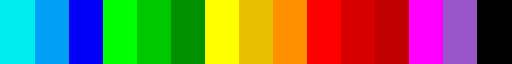

In [30]:
ref_cmap

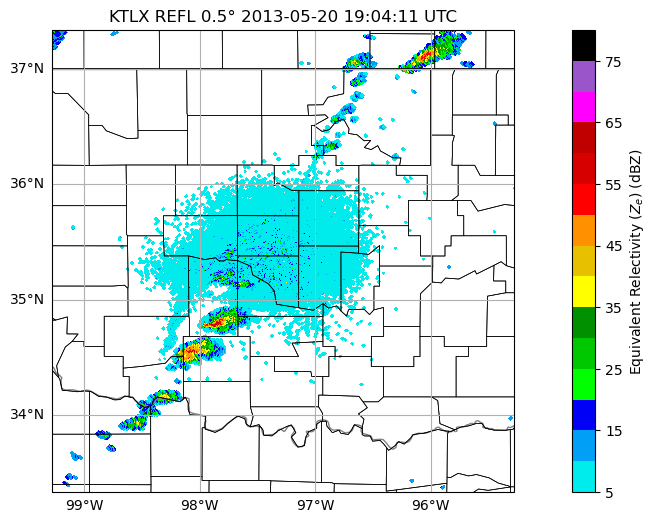

In [31]:
# Call the function that creates the title string, among other things.
timeSweepStr, elevSweepStr = nexRadSweepTimeElev (radar, sweep)
titleStr = f'{site} {shortName} {elevSweepStr} {timeSweepStr}'

# Create our figure
fig = plt.figure(figsize=[15, 6])

# Set up a single axes and plot reflectivity
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent ([lonW, lonE, latS, latN])

display = pyart.graph.RadarMapDisplay(radar)
ref_map = display.plot_ppi_map(field,sweep=sweep, vmin=20, vmax=80, ax=ax, raster=False, title=titleStr,
            colorbar_label='Equivalent Relectivity ($Z_{e}$) (dBZ)', norm=ref_norm, cmap=ref_cmap, resolution=res)
# Add counties
ax.add_feature(USCOUNTIES, linewidth=0.5);

Next, let's create a function to create a plot, so we can loop over all the radar files of the specified hour.

In [32]:
def plot_radar_refl (idx, site, radar):
    proj = ccrs.PlateCarree()
    # New axes with the specified projection
    ax = fig.add_subplot(111, projection=proj)
    ax.set_extent(domain)
    ax.add_feature(USCOUNTIES.with_scale('5m'),edgecolor='grey', linewidth=1, zorder = 3 )
    display = pyart.graph.RadarMapDisplay(radar)
    ref_map = display.plot_ppi_map(field,sweep=sweep, cmap=ref_cmap, norm=ref_norm, ax=ax, colorbar_flag = False, 
                title_flag = False, colorbar_label='Equivalent Relectivity ($Z_{e}$) (dBZ)', resolution=res)
    return ax 

<div class="alert alert-info"><b>Color bar omitted</b> Embedding the colorbar into an animation sequence is non-trivial ... so we do not include a colorbar here.</div>

Loop over the files. Save each image.

In [33]:
backend_ =  matplotlib.get_backend() 
backend_

'module://matplotlib_inline.backend_inline'

Set the Jupyter matplotlib backend to one that will not show the graphics inline (this will save time in notebook execution)

In [34]:
matplotlib.use("Agg")  # Prevent showing stuff

meshes = []
fig = plt.figure(figsize=(10,10))
for n, name in enumerate(files[:]):
    print (n, name, site)
    radar = pyart.io.read_nexrad_archive(f's3://{name}')  
    ax1 = plot_radar_refl(n, site, radar)
    timeSweepStr, elevSweepStr = nexRadSweepTimeElev (radar, sweep)
    titleStr = f'{site} {shortName} {elevSweepStr} {timeSweepStr}' 
    print (titleStr)
    title = ax1.text(0.5,0.92,titleStr,horizontalalignment='center',
     verticalalignment='center', transform=fig.transFigure, fontsize=15)
    meshes.append((ax1,title))

0 noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_190411_V06.gz KTLX
KTLX REFL 0.5° 2013-05-20 19:04:11 UTC
1 noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_190826_V06.gz KTLX
KTLX REFL 0.5° 2013-05-20 19:08:26 UTC
2 noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_191243_V06.gz KTLX
KTLX REFL 0.5° 2013-05-20 19:12:43 UTC
3 noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_191658_V06.gz KTLX
KTLX REFL 0.5° 2013-05-20 19:16:58 UTC
4 noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_192116_V06.gz KTLX
KTLX REFL 0.5° 2013-05-20 19:21:16 UTC
5 noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_192532_V06.gz KTLX
KTLX REFL 0.5° 2013-05-20 19:25:32 UTC
6 noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_192949_V06.gz KTLX
KTLX REFL 0.5° 2013-05-20 19:29:49 UTC
7 noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_193405_V06.gz KTLX
KTLX REFL 0.5° 2013-05-20 19:34:05 UTC
8 noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_193821_V06.gz KTLX
KTLX REFL 0.5° 2013-05-20 19:38:21 UTC
9 noaa-nexrad-level2/2013/05

Set the Jupyter matplotlib backend to the default value, so we see output once again.

In [35]:
matplotlib.use(backend_)

In [36]:
anim = ArtistAnimation(fig, meshes)

In [37]:
anim

In [38]:
anim.save(f'{site}_{timeStr}_refl.mp4')

---
### Things to try
Create an animation for a time and site of interest.
